# imports and loading DataFrame

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import pandas as pd
import numpy as np
import datetime


# fact table
sessions_df = pd.read_json("data/sessions.jsonl", lines=True)

# dimension tables
deliveries_df = pd.read_json("data/deliveries.jsonl", lines=True)
products_df = pd.read_json("data/products.jsonl", lines=True)
users_df = pd.read_json("data/users.jsonl", lines=True)

# constant values

In [2]:
MAKE_PLOTS = True
MAKE_PAIRPLOT = True
DATE_FORMAT = "%Y-%m-%dT%H:%M:%S"
PRICE_TRESHOLD = 100_000    # for outliers
WEIGHT_TRESHOLD = 50        # for outliers
NUM_OF_HOURS = 24
SEED = 42
SHOW_ALL_WARNINGS = False
SHOW_ONLY_ONE_WARNING = False

In [3]:
import warnings

if SHOW_ONLY_ONE_WARNING:
    warnings.filterwarnings(action='once')
elif not SHOW_ALL_WARNINGS:
    warnings.filterwarnings('ignore')

# merging all data into one DataFrame and other transformations

## adding a column with time difference in deliveries
adding a column with time difference between purchase_timestamp and delivery_timestamp in deliveries table

1. Cut microseconds from delivery_timestamp, so it will be the same format as purchase_timestamp, because there are no microseconds in purchase_timestamp (using "." as a separator).
2. Change columns format to datetime
3. Add time_diff column (as timedelta64 object).
4. Drop rows where time_diff is null (which means that delivery_timestamp was null).
5. Change type of time_diff from timedelta64 to seconds in float.
6. Drop rows where time_diff is below 0. THIS STEP IS MADE IN ### without time_diff below 0

In [4]:
# 1.
deliveries_df["delivery_timestamp"] = deliveries_df["delivery_timestamp"].str.split('.', expand=True)[0]

# 2.
deliveries_df["purchase_timestamp"] = pd.to_datetime(deliveries_df["purchase_timestamp"], format=DATE_FORMAT)
deliveries_df["delivery_timestamp"] = pd.to_datetime(deliveries_df["delivery_timestamp"], format=DATE_FORMAT)

# 3.
deliveries_df["time_diff"] = deliveries_df["delivery_timestamp"] - deliveries_df["purchase_timestamp"]

# 4.
deliveries_df = deliveries_df[deliveries_df["time_diff"].notna()]

# 5.
# time diff as duration in seconds
deliveries_df["time_diff"] = deliveries_df["time_diff"].apply(datetime.timedelta.total_seconds)

# 6.
# deliveries_df = deliveries_df[deliveries_df["time_diff"] >= 0]

## join deliveries with sessions

In [5]:
# drop rows where event_type is not equal "BUY_PRODUCT"
sessions_df = sessions_df[sessions_df["event_type"] == "BUY_PRODUCT"]
df = deliveries_df.merge(sessions_df, on="purchase_id", how="left")

In [6]:
# making sure, that timestamp == purchase_timestamp
num_of_rows_before = df.shape[0]
df = df[df["timestamp"] == df["purchase_timestamp"]]
num_of_rows_after = df.shape[0]

assert(num_of_rows_before == num_of_rows_after)

# now we can drop timestamp column, as it is redundant
df = df.drop(columns="timestamp")

## join with other tables

In [7]:
df = df.merge(users_df, on="user_id", how="left")
df = df.merge(products_df, on="product_id", how="left")

# missing data analysis - MCAR, MAR, MNAR

made without outliers but with prices below zero (on copy of df)

In [8]:
missing_data_df = df.copy(deep=False)
missing_data_df["delivery_company_is_missing"] = missing_data_df["delivery_company"].isna()
missing_data_df["user_id_is_missing"] = missing_data_df["user_id"].isna()
missing_data_df["product_id_is_missing"] = missing_data_df["product_id"].isna()

In [9]:
# rejecting outliers for given PRICE_TRESHOLD
missing_data_df = missing_data_df[missing_data_df["price"] <= PRICE_TRESHOLD]

# rejecting outliers for given WEIGHT_TRESHOLD
missing_data_df = missing_data_df[missing_data_df["weight_kg"] <= WEIGHT_TRESHOLD]

In [10]:
NUM_BINS_MISSING = 50

def compare_histograms_for_missing(input_df1, input_df2, end_of_title1="", end_of_title2=""):
    fig, ax = plt.subplots(4, 2)
    
    def plot_histograms_missing(input_df, plot_column, end_of_title=""):

        def plot_hist_missing(x, y, col_name, num_bins=None):
            if num_bins:
                ax[x, y].hist(input_df[col_name], bins=num_bins)
            else:
                ax[x, y].hist(input_df[col_name])
            ax[x, y].set_title(f"histogram of {col_name}" + end_of_title)
            ax[x, y].set_xlabel(col_name)
            ax[x, y].set_ylabel("# of observations")

        plot_hist_missing(0, plot_column, "time_diff", NUM_BINS_MISSING)
        plot_hist_missing(1, plot_column, "offered_discount", NUM_BINS_MISSING)
        plot_hist_missing(2, plot_column, "price", NUM_BINS_MISSING)
        plot_hist_missing(3, plot_column, "weight_kg", NUM_BINS_MISSING)

    plot_histograms_missing(input_df1, 0, end_of_title1)
    plot_histograms_missing(input_df2, 1, end_of_title2)

    fig.set_size_inches([24, 21])
    plt.show()

## delivery_company missing

In [11]:
no_missing_delivery_company = missing_data_df[missing_data_df["delivery_company_is_missing"] == False]
missing_delivery_company = missing_data_df[missing_data_df["delivery_company_is_missing"] == True]

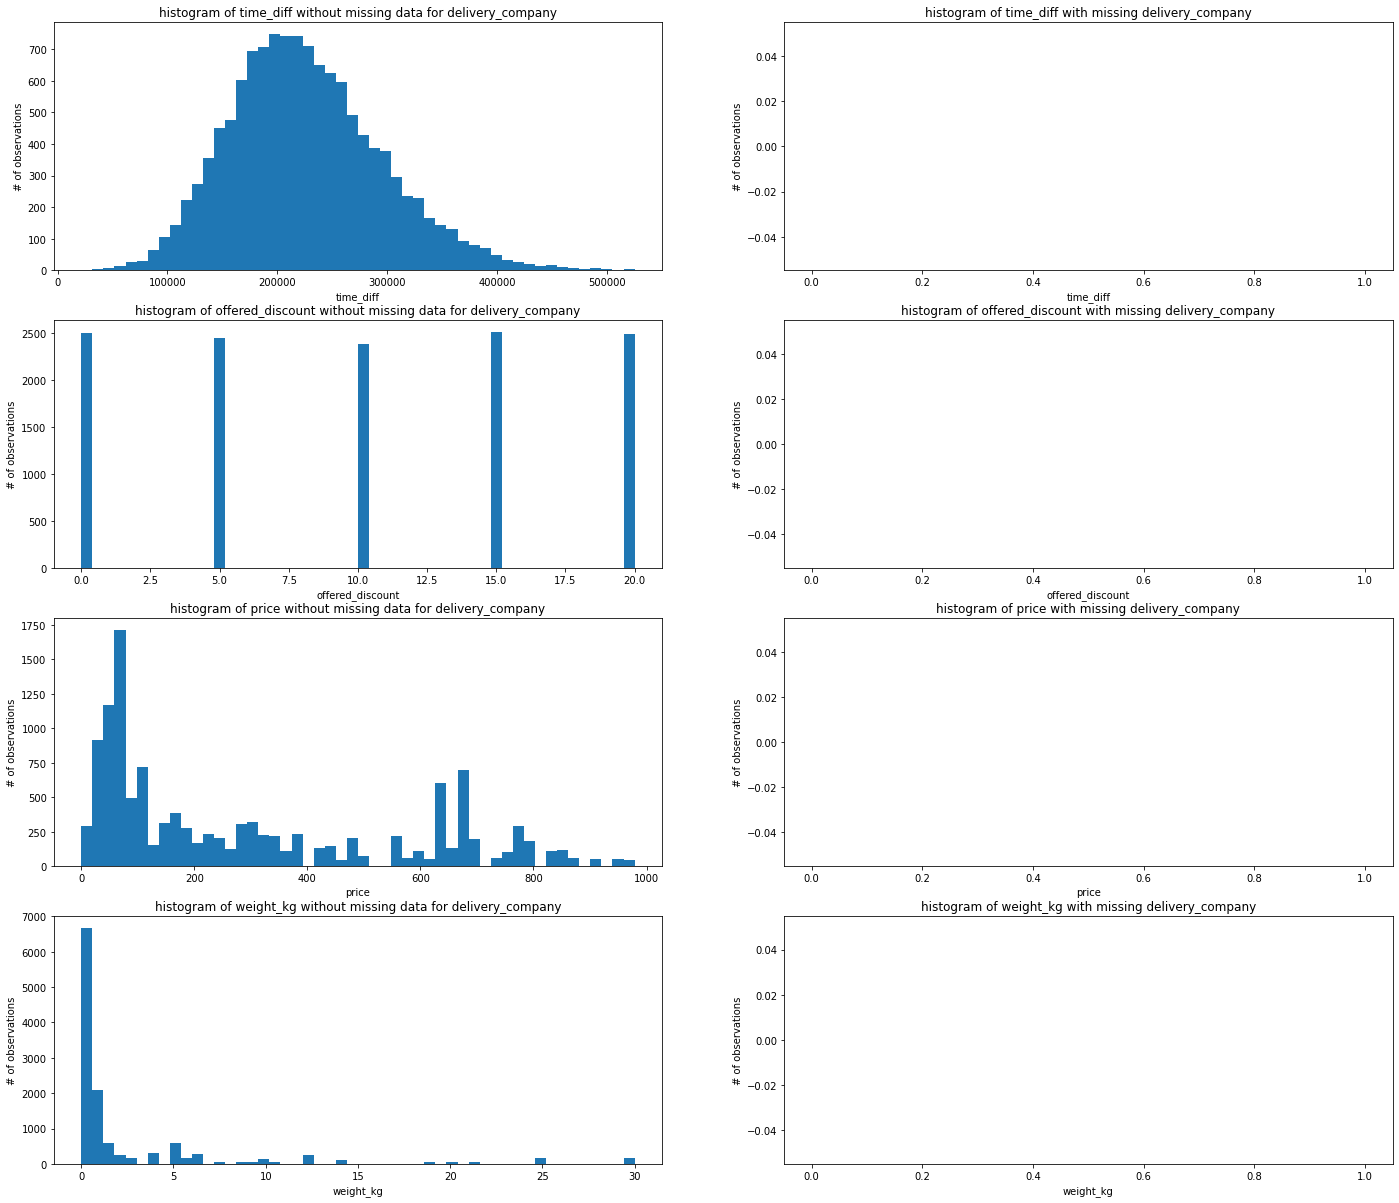

In [12]:
if MAKE_PLOTS:
    compare_histograms_for_missing(no_missing_delivery_company, missing_delivery_company, " without missing data for delivery_company", " with missing delivery_company")

## user_id missing

In [13]:
no_missing_user_id = missing_data_df[missing_data_df["user_id_is_missing"] == False]
missing_user_id = missing_data_df[missing_data_df["user_id_is_missing"] == True]

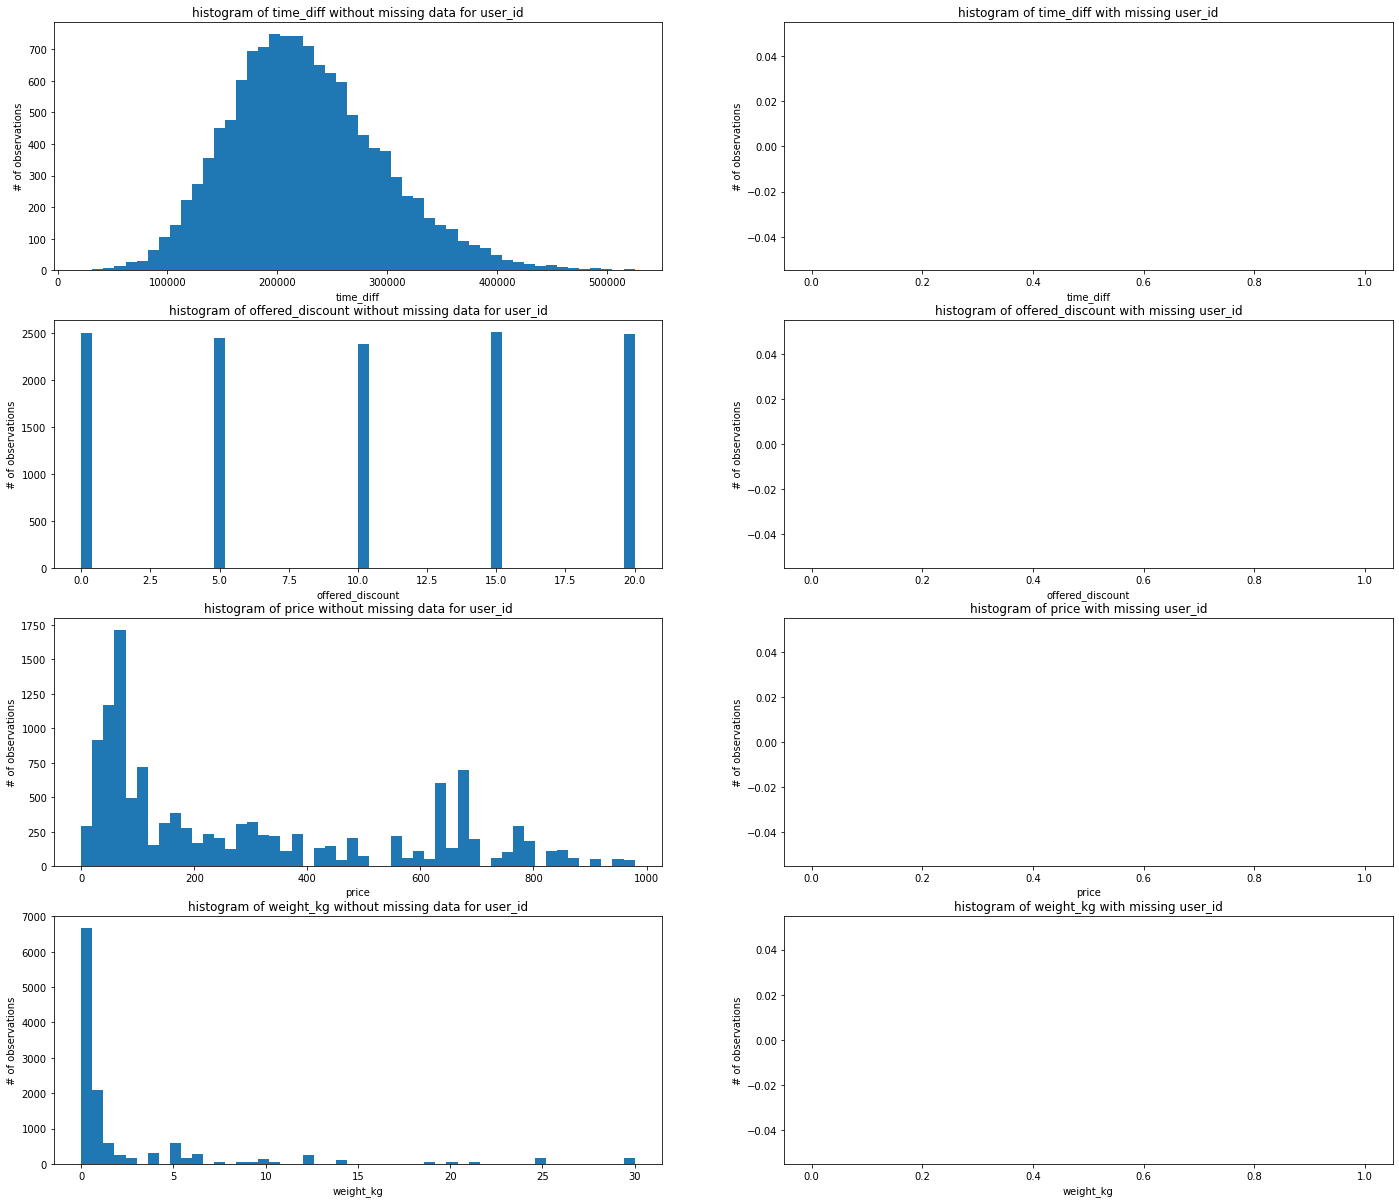

In [14]:
if MAKE_PLOTS:
    compare_histograms_for_missing(no_missing_user_id, missing_user_id, " without missing data for user_id", " with missing user_id")

## product_id missing
this analysis doesn't make sense

In [15]:
no_missing_product_id = missing_data_df[missing_data_df["product_id_is_missing"] == False]
missing_product_id = missing_data_df[missing_data_df["product_id_is_missing"] == True]

In [16]:
# if MAKE_PLOTS:
#     compare_histograms_for_missing(no_missing_product_id, missing_product_id, " without missing data for product_id", " with missing product_id")

# width, height, depth - normalize optional_attributes

In [17]:
optional_attributes_df = pd.json_normalize(df['optional_attributes'])

In [18]:
display(optional_attributes_df.head())
display(optional_attributes_df.info())
display(optional_attributes_df.describe())

,color,height_cm,width_cm,depth_cm
0,czarny,NaN,NaN,NaN
1,czarny,NaN,NaN,NaN
2,czarny,43.50,16.90,35.60
3,czarny,20.00,23.00,18.20
4,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12428 entries, 0 to 12427
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   color      5708 non-null   object
 1   height_cm  1229 non-null   object
 2   width_cm   1229 non-null   object
 3   depth_cm   1229 non-null   object
dtypes: object(4)
memory usage: 388.5+ KB


None

,color,height_cm,width_cm,depth_cm
count,5708,1229,1229,1229
unique,8,13,15,15
top,czarny,43.50,16.90,35.60
freq,4643,274,274,274


In [19]:
display(optional_attributes_df.nunique())

color         8
height_cm    13
width_cm     15
depth_cm     15
dtype: int64

To co mogłoby nas zainteresować to width_cm, height_cm oraz depth_cm. Niestety atrybuty te występują tylko w około 10% przypadków (1116 na 11452), przez co nie zostaną one wykorzystane.

In [20]:
# df[['color', 'width_cm', 'height_cm', 'depth_cm']] = pd.json_normalize(df['optional_attributes'])

# visualizations

## time_diff histogram and log-normal distribution test

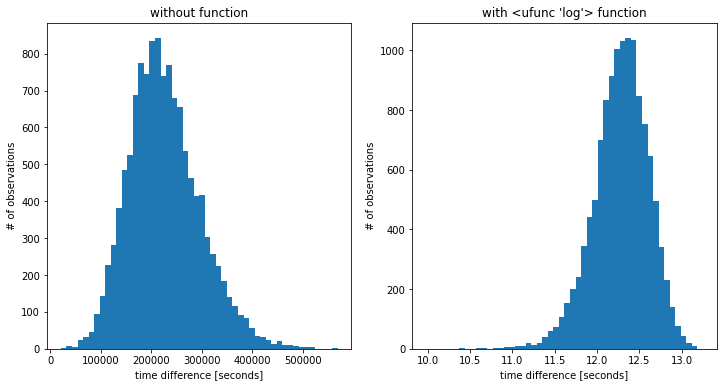

In [21]:
if MAKE_PLOTS:
    fig, ax = plt.subplots(1, 2)

    def plot_hist(x, num_bins=50, func=None):
        if func:
            ax[x].hist(func(df["time_diff"]), bins=num_bins)
            ax[x].set_title(f"with {func} function")
        else:
            ax[x].hist(df["time_diff"], bins=num_bins)
            ax[x].set_title(f"without function")
        ax[x].set_xlabel("time difference [seconds]")
        ax[x].set_ylabel("# of observations")

    plot_hist(0)
    plot_hist(1, func=np.log)
    # plot_hist(1, 0, func=np.log2)
    # plot_hist(1, 1, func=np.log10)

    fig.set_size_inches([12, 6])
    plt.show()

## histograms of continuous variables

In [22]:
NUM_BINS = 50


def plot_histograms(input_df):
    fig, ax = plt.subplots(2, 2)

    def plot_hist(x, y, col_name, num_bins=None):
        if num_bins:
            ax[x, y].hist(input_df[col_name], bins=num_bins)
        else:
            ax[x, y].hist(input_df[col_name])
        ax[x, y].set_title(f"histogram of {col_name}")
        ax[x, y].set_xlabel(col_name)
        ax[x, y].set_ylabel("# of observations")

    plot_hist(0, 0, "time_diff", NUM_BINS)
    plot_hist(0, 1, "offered_discount", NUM_BINS)
    plot_hist(1, 0, "price", NUM_BINS)
    plot_hist(1, 1, "weight_kg", NUM_BINS)

    fig.set_size_inches([12, 12])
    plt.show()

### with outliers

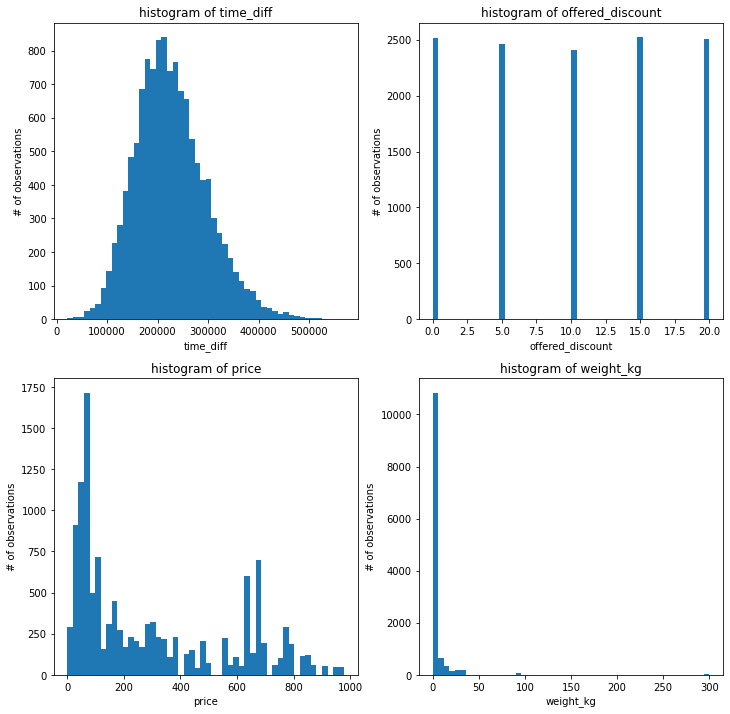

In [23]:
if MAKE_PLOTS:
    plot_histograms(df)

### without outliers

In [24]:
# rejecting outliers for given PRICE_TRESHOLD
df = df[df["price"] <= PRICE_TRESHOLD]

# rejecting outliers for given WEIGHT_TRESHOLD
df = df[df["weight_kg"] <= WEIGHT_TRESHOLD]

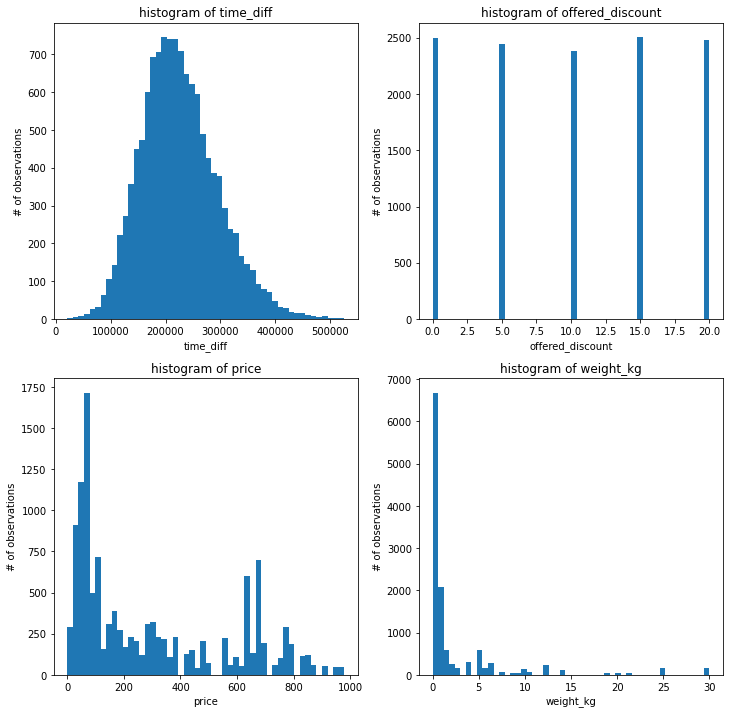

In [25]:
if MAKE_PLOTS:
    plot_histograms(df)

### without prices below 0

In [26]:
# deleting rows with prices below 0
df = df[df["price"] >= 0]

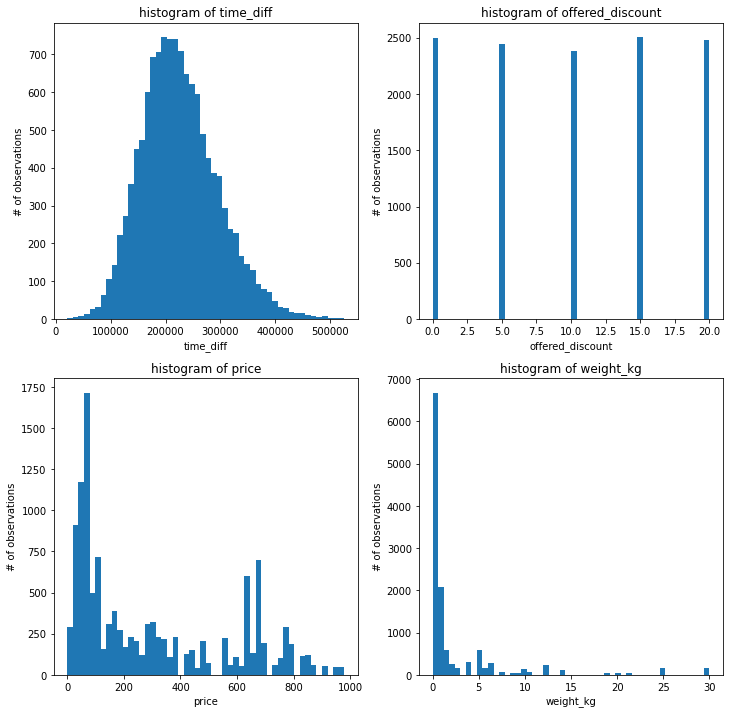

In [27]:
if MAKE_PLOTS:
    plot_histograms(df)

### without time_diff below 0

In [28]:
df_with_time_diff_below_0 = df
df = df[df["time_diff"] >= 0]

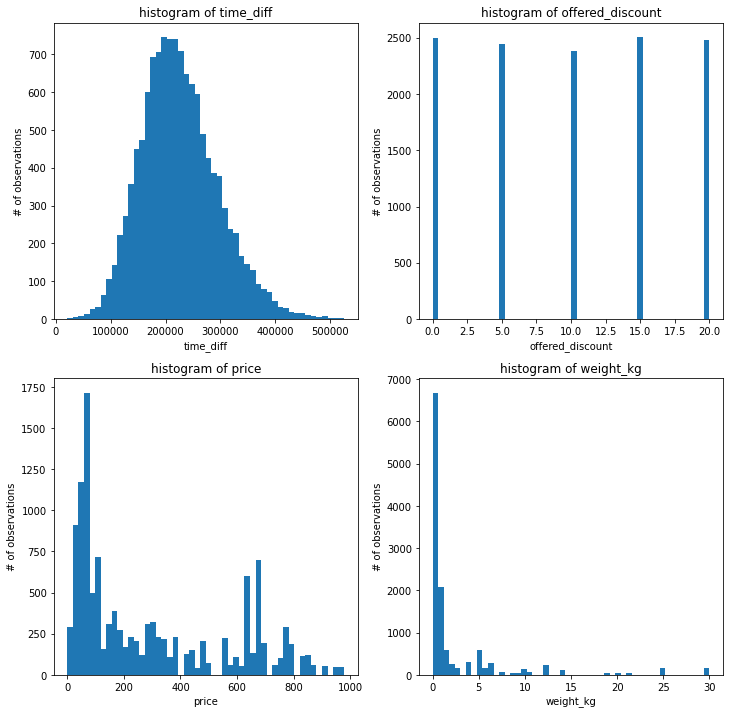

In [29]:
if MAKE_PLOTS:
    plot_histograms(df)

## heatmap

### with time_diff below zero

In [30]:
def update_list_of_columns():
    banned_list_of_columns = ["purchase_id", "delivery_company", "session_id", "user_id", "product_id"]
    columns_list = [col for col in df.columns.values.tolist() if col not in banned_list_of_columns]
    return columns_list

columns_list = update_list_of_columns()

(12320, 19)


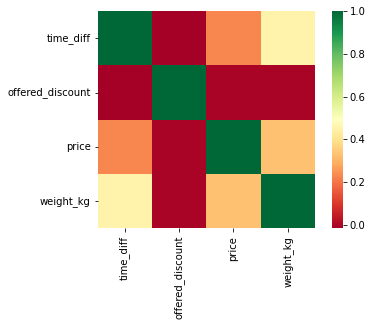

In [31]:
if MAKE_PLOTS:
    print(df_with_time_diff_below_0.shape)
    ax = sns.heatmap(df_with_time_diff_below_0[columns_list].corr(), square=True, cmap='RdYlGn')

### without time_diff below zero

#### pearson

(12320, 19)


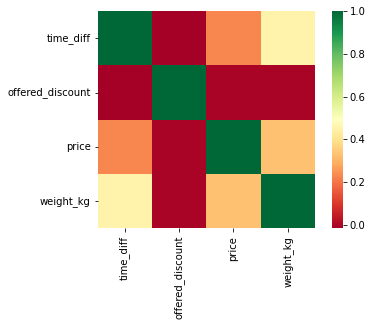

In [32]:
if MAKE_PLOTS:
    print(df.shape)
    ax = sns.heatmap(df[columns_list].corr('pearson'), square=True, cmap='RdYlGn')

#### spearman

(12320, 19)


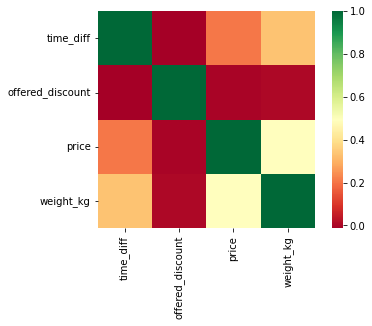

In [33]:
if MAKE_PLOTS:
    print(df.shape)
    ax = sns.heatmap(df[columns_list].corr('spearman'), square=True, cmap='RdYlGn')

#### kendall

In [34]:
# if MAKE_PLOTS:
#     print(df.shape)
#     ax = sns.heatmap(df[columns_list].corr('kendall'), square=True, cmap='RdYlGn')

## Pairplot

In [35]:
df.isnull().values.any()

False

In [36]:
df_temp = df.drop(columns='optional_attributes')
df_temp.nunique().sort_values()

event_type                1
delivery_company          3
offered_discount          5
city                      7
category_path            23
brand                    57
weight_kg               111
price                   143
product_id              162
product_name            162
name                    398
street                  398
user_id                 398
time_diff             12003
delivery_timestamp    12315
purchase_timestamp    12318
session_id            12320
purchase_id           12320
dtype: int64

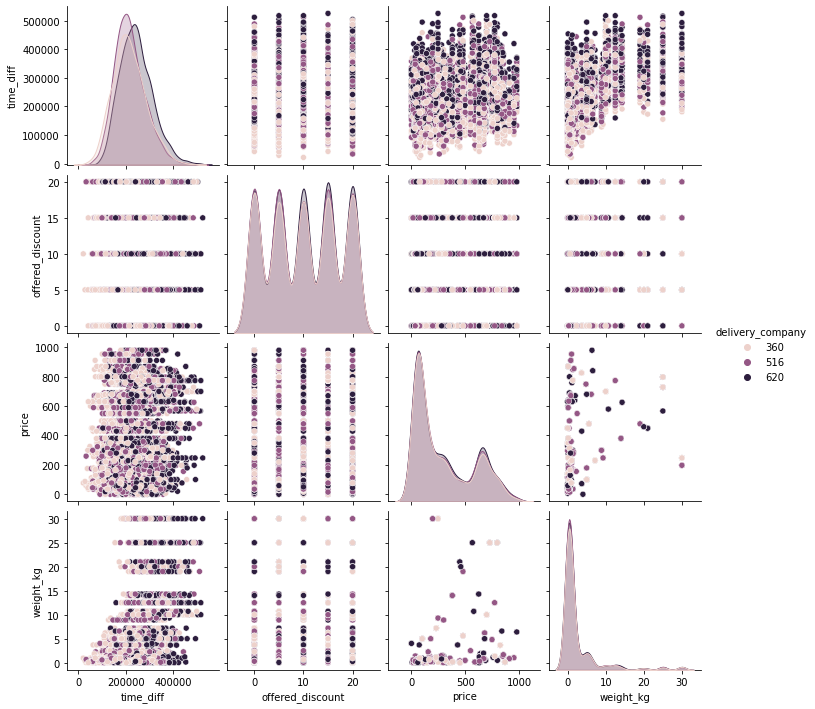

In [37]:
if MAKE_PLOTS and MAKE_PAIRPLOT:
    columns_to_drop_for_pairplot = ['purchase_id', 'session_id', 'user_id', 'product_id']
    df_for_pairplot = df.drop(columns=columns_to_drop_for_pairplot)
    g = sns.pairplot(df_for_pairplot, kind='scatter', hue='delivery_company')

Na pierwszy rzut oka atrybut delivery_company nie ma tak dużego znaczenia - spodziewaliśmy się większego zróżnicowania.

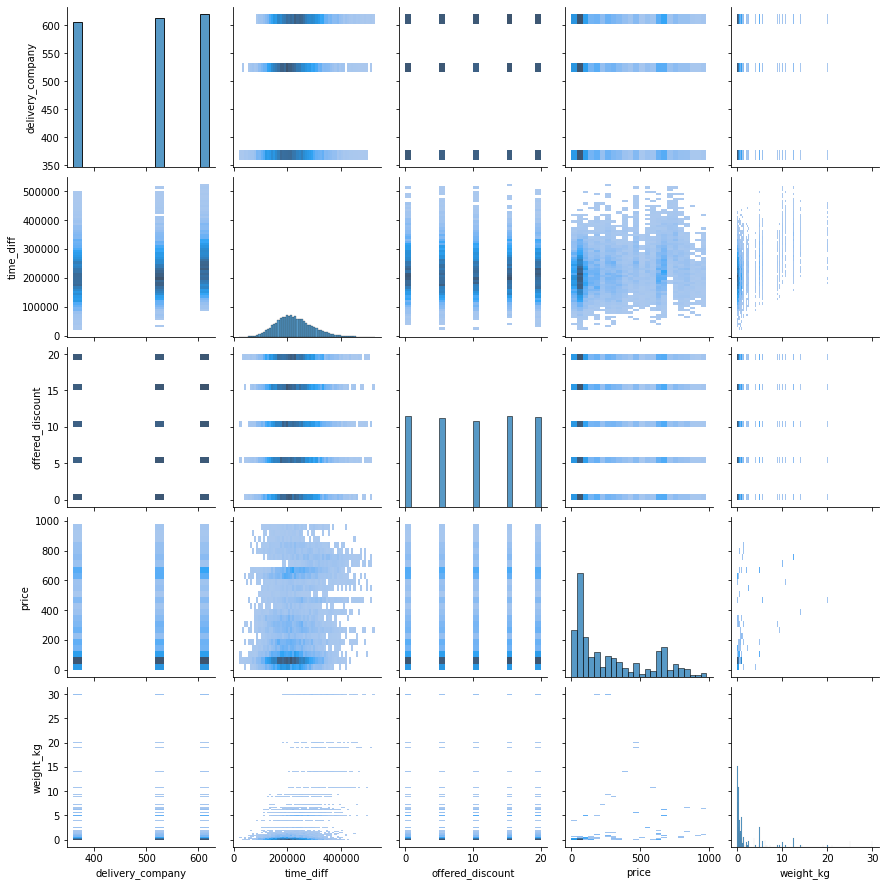

In [38]:
if MAKE_PLOTS and MAKE_PAIRPLOT:
    columns_to_drop_for_pairplot = ['purchase_id', 'session_id', 'user_id', 'product_id']
    df_for_pairplot = df.drop(columns=columns_to_drop_for_pairplot)
    g = sns.pairplot(df_for_pairplot, kind='hist')

## visualizing time series

(array([1835., 1720., 1625., 1482., 1292., 1145.,  945.,  763.,  500.,
        1013.]),
 array([ 8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18.]),
 <BarContainer object of 10 artists>)

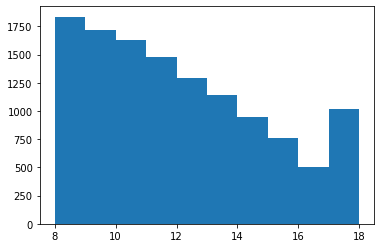

In [39]:
plt.hist(df['delivery_timestamp'].dt.hour)

In [40]:
df['purchase_timestamp'].nunique()

12318

In [41]:
time_series_df = df.copy()
time_series_df['purchase_date'] = time_series_df['purchase_timestamp'].dt.date
time_series_df = time_series_df.groupby(['purchase_date']).mean()
time_series_df.index = pd.to_datetime(time_series_df.index)
# time_series_df = time_series_df.reset_index()
# time_series_df['purchase_date'].nunique()
print(time_series_df.index.nunique())
display(time_series_df.head())
display(time_series_df.tail())

366


,purchase_id,delivery_company,time_diff,session_id,user_id,product_id,offered_discount,price,weight_kg
purchase_date,,,,,,,,,
2021-05-23,26329.800000,495.200000,200913.600000,10681.050000,299.050000,1172.800000,10.000000,260.795000,3.489150
2021-05-24,26247.729730,483.675676,210787.486486,10544.351351,296.729730,1204.675676,9.189189,251.982432,2.150324
2021-05-25,27116.230769,501.333333,204409.615385,12000.128205,324.102564,1209.820513,10.384615,321.956667,1.739385
2021-05-26,26412.583333,513.111111,203238.111111,10818.611111,301.750000,1224.805556,8.472222,244.382500,0.954806
2021-05-27,26264.416667,471.222222,253754.916667,10564.777778,297.083333,1225.611111,9.861111,312.664722,3.412222


,purchase_id,delivery_company,time_diff,session_id,user_id,product_id,offered_discount,price,weight_kg
purchase_date,,,,,,,,,
2022-05-19,25769.724138,494.482759,258683.275862,9747.241379,279.965517,1156.275862,8.620690,356.946552,2.431690
2022-05-20,25961.828571,453.600000,252582.171429,10065.971429,287.228571,1189.228571,9.571429,303.234857,1.881829
2022-05-21,26396.413793,467.586207,212049.103448,10794.620690,300.275862,1255.137931,9.655172,354.147241,0.954034
2022-05-22,26218.235294,500.705882,218451.911765,10486.970588,295.735294,1183.941176,8.823529,337.659118,1.645824
2022-05-23,26389.172414,499.862069,215454.896552,10783.310345,300.586207,1155.379310,9.310345,238.540000,3.010517


### 1. trend analysis - moving average

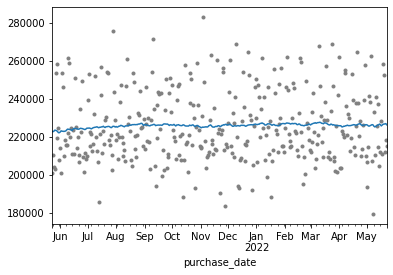

In [42]:
if MAKE_PLOTS:
    moving_average = time_series_df['time_diff'].rolling(
        window=90,
        center=True,
        min_periods=45
    ).mean()
    
    fig, ax = plt.subplots()
    ax.scatter(time_series_df.index, time_series_df['time_diff'], marker='.', color='0.5')
    moving_average.plot(ax=ax)
    plt.show()

Jak widać wartość średnia z 3 miesięcy w okolicach sierpnia lekko rośnie, a w okolicach marca zaczyna powoli spadać. Natomiast można raczej powiedzieć, że trend jest mniej więcej stały.

### 2. time dependence (seasonality) analysis

#### weekly seasonality with indicators

##### function

In [43]:
# source: https://www.kaggle.com/code/ryanholbrook/seasonality

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

##### weekly seasonality plot

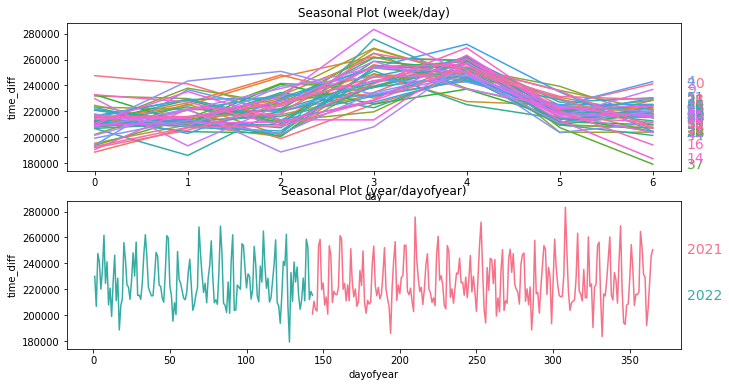

In [44]:
X = time_series_df.copy()

X["day"] = X.index.dayofweek
X["week"] = X.index.week

X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year

if MAKE_PLOTS:
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
    seasonal_plot(X, y="time_diff", period="week", freq="day", ax=ax0)
    seasonal_plot(X, y="time_diff", period="year", freq="dayofyear", ax=ax1)

Powyżej widzimy, że dzień tygodnia ma znaczenie - na przykład z czwartego na piąty dzień tygodnia prawie zawsze widać znaczny spadek średniego czasu dostawy.

Natomiast na wykresie przedstawiającym okres roczny ciężko znaleźć jakieś zależności.

Wykryta sezonowość na przestrzeni tygodnia zostanie uwzględniona w modelu za pomocą wskaźników (indicators) poprzez one-hot encoding.

Warto dodać, że na powyższym wykresie widać, że średnia wartość time_diff dla kolejnych dni mocno skacze góra-dół. Być może są tam jakieś cykle, które uda się wykryć w kolejnym punkcie.

In [45]:
df['day_of_week'] = df['purchase_timestamp'].dt.dayofweek

#### periodogram - seasonality with fourier features

##### function

In [46]:
# source: https://www.kaggle.com/code/ryanholbrook/seasonality

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

##### periodogram plot

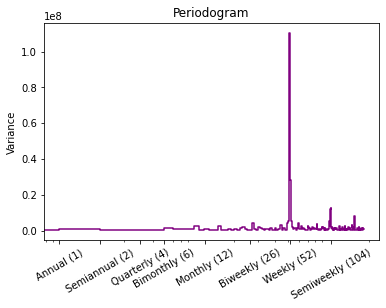

In [47]:
if MAKE_PLOTS:
    plot_periodogram(time_series_df["time_diff"])

Zgodnie z wcześniejszymi spostrzeżeniami na powyższym wykresie widzimy silną zależność tygodniową. Widać także brak silnych zależności w przypadku okresów dłuższych - takich jak miesiąc czy rok.

Nie jest natomiast pewne czy udzielimy to w modelu. Nie mamy pewnego pomysłu jak to zrobić - być może by wymagało to dodatkowego modelu, który przewiduje średni czas dostawy danego dnia. Poza tym zależność tygodniowa prawdopodobnie jest skorelowana z tym, jaki jest dzień tygodnia (poprzedni punkt), co zostanie zamodelowane.

### 3. serial dependence (cycles) analysis

#### function

In [48]:
# source: https://www.kaggle.com/code/ryanholbrook/time-series-as-features

from statsmodels.graphics.tsaplots import plot_pacf

def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

#### lags comparison and autocorrelation

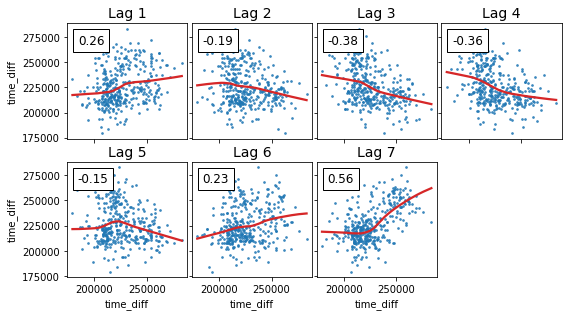

In [49]:
if MAKE_PLOTS:
    fig = plot_lags(time_series_df["time_diff"], lags=7, nrows=2)

#### partial autocorrelation

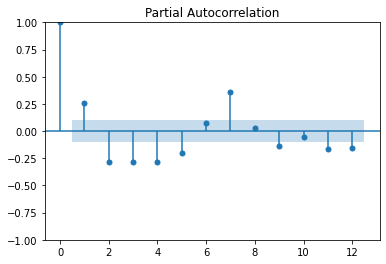

In [50]:
if MAKE_PLOTS:
    fig = plot_pacf(time_series_df["time_diff"], lags=12)

Powyższy wykres w okolicach 120 jest prawdopodobnie niepoprawny. Te korelacje też prawdopodobnie odpuścimy, ponieważ musimy pamiętać o tym, że są to korelacje ze średnim czasem dostawy danego dnia, co musiałoby się pośrednio przenieść na przewidywanie czasu dostawy dla konkretnego zamówienia. Z całej powyższej analizy szeregów czasowych ograniczymy się więc do dodania atrybutu z informacją o dniu tygodnia.

In [51]:
# lag = 119
# display(time_series_df.time_diff.iloc[5:10])
# display(time_series_df.time_diff.iloc[0+lag:5+lag])

# feature engineering

In [52]:
cols_to_drop_after_feature_engineering = set()

## interactions

### city and street

In [53]:
df['city_and_street'] = df['city'] + ' ' + df['street']
display(df[['city_and_street', 'city', 'street']])

,city_and_street,city,street
0,Poznań plac Dębowa 11/53,Poznań,plac Dębowa 11/53
1,Poznań plac Dębowa 11/53,Poznań,plac Dębowa 11/53
2,Poznań plac Dębowa 11/53,Poznań,plac Dębowa 11/53
3,Poznań plac Dębowa 11/53,Poznań,plac Dębowa 11/53
4,Poznań plac Dębowa 11/53,Poznań,plac Dębowa 11/53
...,...,...,...
12423,Poznań ul. Zachodnia 88,Poznań,ul. Zachodnia 88
12424,Poznań ul. Zachodnia 88,Poznań,ul. Zachodnia 88
12425,Poznań ul. Zachodnia 88,Poznań,ul. Zachodnia 88
12426,Poznań ul. Zachodnia 88,Poznań,ul. Zachodnia 88


## purchase timestamp

In [54]:

df['purchase_datetime_delta'] = (df['purchase_timestamp'] - df['purchase_timestamp'].min())  / np.timedelta64(1,'D')

## mutual information

In [55]:
feature_eng_df = df.copy()
feature_eng_df = feature_eng_df.infer_objects()
feature_eng_df = feature_eng_df.set_index('purchase_timestamp').sort_index()
feature_eng_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12320 entries, 2021-05-23 14:05:51 to 2022-05-23 19:22:00
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   purchase_id              12320 non-null  int64         
 1   delivery_timestamp       12320 non-null  datetime64[ns]
 2   delivery_company         12320 non-null  int64         
 3   time_diff                12320 non-null  float64       
 4   session_id               12320 non-null  int64         
 5   user_id                  12320 non-null  int64         
 6   product_id               12320 non-null  int64         
 7   event_type               12320 non-null  object        
 8   offered_discount         12320 non-null  int64         
 9   name                     12320 non-null  object        
 10  city                     12320 non-null  object        
 11  street                   12320 non-null  object        
 1

In [56]:
cols_to_drop_feature_eng = ['delivery_timestamp',
                            'event_type',
                            'optional_attributes',
                            'purchase_id',
                            'session_id',
                            'user_id',
                            'product_id']
feature_eng_df = feature_eng_df.drop(columns=cols_to_drop_feature_eng)

In [57]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

BIN_SIZE = 2

def make_mi_scores(in_df, y, reg_version=True, bin_size=BIN_SIZE):
    X = in_df.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    # display(X.info())
    # display(X.nunique())
    # display(X)
    # display(X.describe())
    # print('discrete_features:')
    # temp_df = pd.DataFrame({'col_name' : X.columns, 'discrete_features' : discrete_features})
    # display(temp_df)
    if reg_version:
        mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0, n_neighbors=bin_size)
    else:
        mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0, n_neighbors=bin_size)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def create_mi_plot(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

def plot_mi_for_col(in_df, col_name='time_diff', reg_version=True):
    X = in_df.copy()
    y = X.pop(col_name)
    mi_scores = make_mi_scores(X, y, reg_version)
    create_mi_plot(mi_scores)

In [58]:
mi_score_df = feature_eng_df.copy()

# these columns give errors in mutual_info_regression
# changing their type to float makes them seen as continuous instead of discrete
# mi_score_df['purchase_id'] = mi_score_df['purchase_id'].astype(float)
# mi_score_df['session_id'] = mi_score_df['session_id'].astype(float)
# ^ but these columns were eventually dropped

### for target (time diff)

In [59]:
def get_mi_for_bin_size(in_df, col_name='time_diff', reg_version=True, bin_size=3):
    X = in_df.copy()
    y = X.pop(col_name)
    mi_scores = make_mi_scores(X, y, reg_version, bin_size)
    return mi_scores

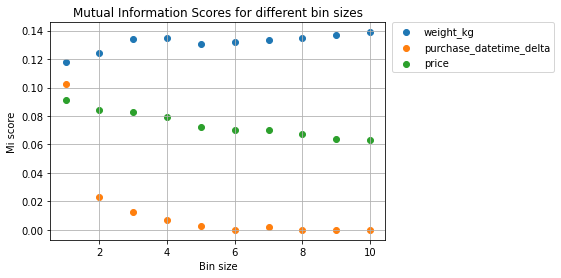

In [60]:
# find best bin_size for weight_kg column
bin_sizes = np.linspace(1, 10, 10).astype(int)
mi_bin_df = pd.DataFrame()
for size in bin_sizes:
    mi_scores = get_mi_for_bin_size(mi_score_df[['weight_kg', 'price', 'purchase_datetime_delta', 'time_diff']], bin_size=size)
    mi_bin_df = mi_bin_df.append(mi_scores)

fig, ax = plt.subplots()
for col_num in range(len(mi_bin_df.columns)):
    ax.scatter(bin_sizes, mi_bin_df.iloc[:, col_num], label=mi_bin_df.columns[col_num])
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax.set_title('Mutual Information Scores for different bin sizes')
ax.set_xlabel('Bin size')
ax.set_ylabel('Mi score')
ax.grid(True)

W takim wypadku bin_size ustawimy na 2.

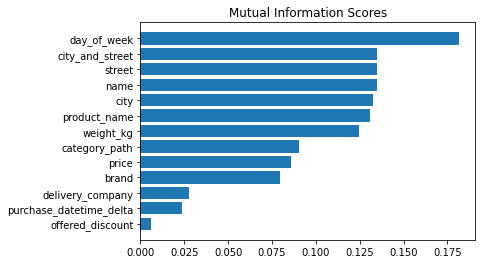

In [61]:
if MAKE_PLOTS:
    plot_mi_for_col(mi_score_df, 'time_diff')

- street, name i user_id są prawdopodobnie nadmiarowe i wystarczy wybrać jeden z tych atrybutów. Zostanie to potwierdzone w następnym punkcie.
- city jest istotnym atrybutem, co widać także na poniższych wykresach
- product_name, product_id i weight_kg być może także są redundantne. Zostanie to sprawdzone dalej.
- weight_kg na pewno będzie brane pod uwagę przez korelację liniową
- decyzje co do pozostałych atrybutów zostaną podjęte później

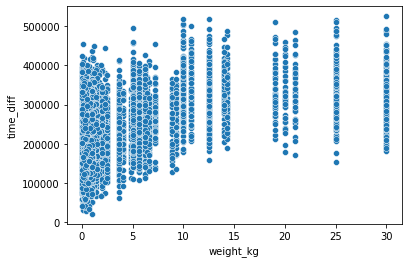

In [62]:
if MAKE_PLOTS:
    g = sns.scatterplot(x='weight_kg', y='time_diff', data=df)

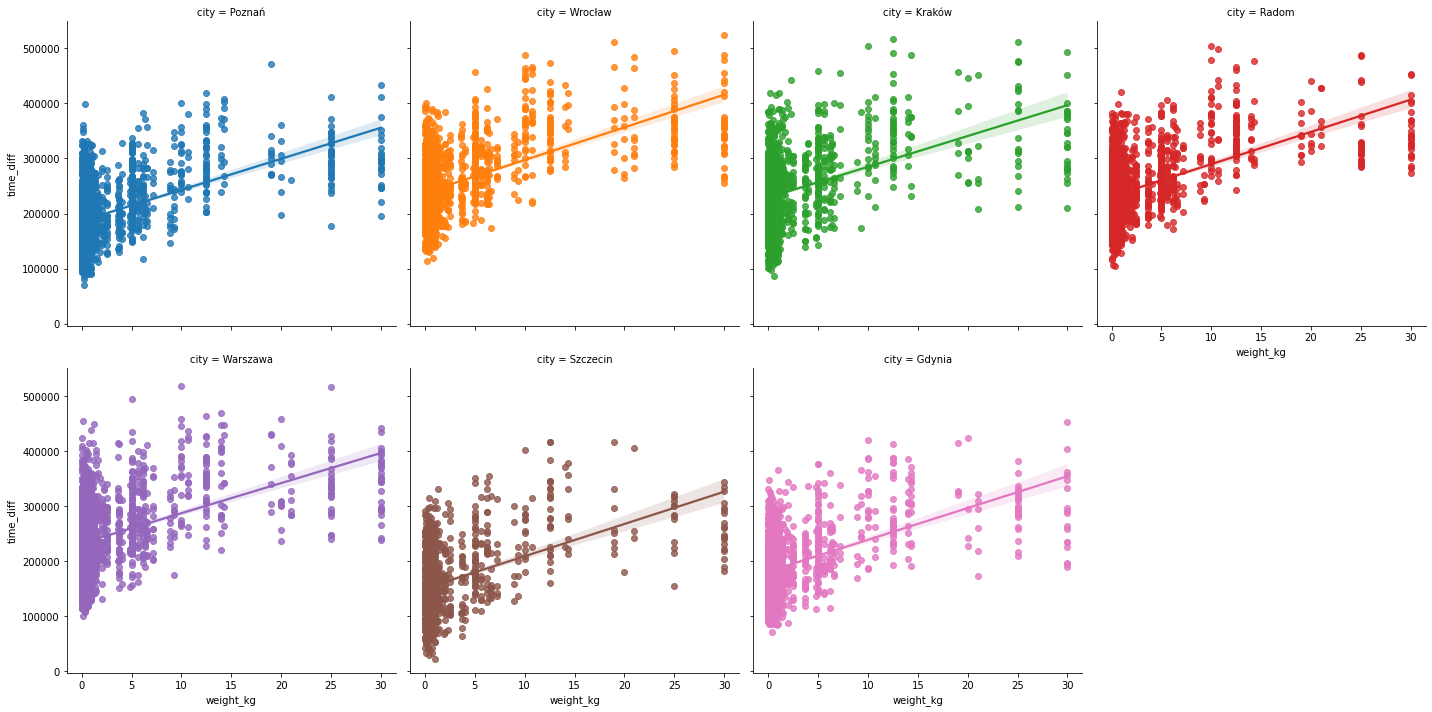

In [63]:
if MAKE_PLOTS:
    g = sns.lmplot(x='weight_kg', y='time_diff', col='city', hue='city', col_wrap=4, data=df)

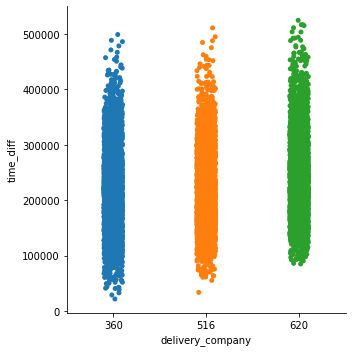

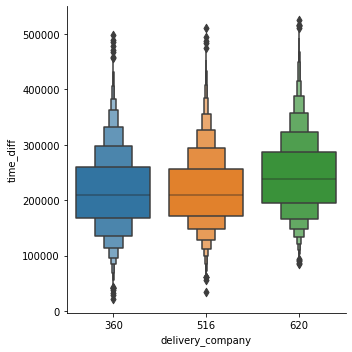

In [64]:
if MAKE_PLOTS:
    sns.catplot(x='delivery_company', y='time_diff', data=df)
    sns.catplot(x='delivery_company', y='time_diff', data=df, kind='boxen')

### for street

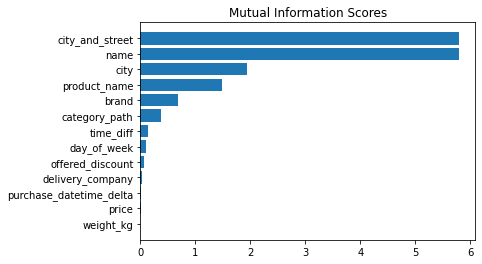

In [65]:
if MAKE_PLOTS:
    plot_mi_for_col(mi_score_df, 'street', reg_version=False)

Jak widać dla street atrybuty name, i user_id są reduntantne. Z tych trzech atrybutów wybrany zostanie street, ponieważ w razie przeprowadzki wciąż będzie on niósł ze sobą ważną informację, podczas gdy nazwa użytkownika lub jego identyfikator pozostanie taki sam i może powodować gorsze działanie modelu.

Oprócz tego atrybuty session_id i purchase_id także zostaną od razu dodane do listy atrybutów, które należy wyrzucić - są to tylko identyfikatory, które generowane są dla każdego nowego zamówienia i nie ma w tym żadnych zależności.

In [66]:
cols_to_drop_after_feature_engineering.update(['name', 'user_id', 'session_id', 'purchase_id'])
mi_score_df = mi_score_df.drop(columns=list(cols_to_drop_after_feature_engineering), errors='ignore')

### for product_name

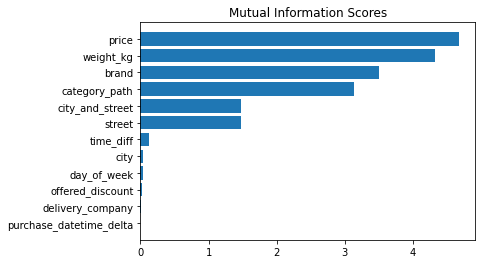

In [67]:
if MAKE_PLOTS:
    plot_mi_for_col(mi_score_df, 'product_name', reg_version=False)

Tutaj wybrany zostanie product_id, a odrzucony product_name.

In [68]:
cols_to_drop_after_feature_engineering.update(['product_name'])
mi_score_df = mi_score_df.drop(columns='product_name')

# dropping columns (choosing attributes)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12320 entries, 0 to 12427
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   purchase_id              12320 non-null  int64         
 1   purchase_timestamp       12320 non-null  datetime64[ns]
 2   delivery_timestamp       12320 non-null  datetime64[ns]
 3   delivery_company         12320 non-null  int64         
 4   time_diff                12320 non-null  float64       
 5   session_id               12320 non-null  int64         
 6   user_id                  12320 non-null  int64         
 7   product_id               12320 non-null  int64         
 8   event_type               12320 non-null  object        
 9   offered_discount         12320 non-null  int64         
 10  name                     12320 non-null  object        
 11  city                     12320 non-null  object        
 12  street                   12320 n

Oprócz kolumn zdefiniowanych do odrzucenia w sekcji feature engineering, odrzucamy także:
1. delivery_timestamp, ponieważ przeciwnym wypadku mielibyśmy przeciek danych (informacja z przyszłości, dzięki której dokładnie moglibyśmy przewidzieć czas dostawy)
2. event_type, ponieważ jest tam tylko jedna wartość

In [70]:
# drop columns
ADDITIONAL_COLUMNS_TO_DROP = ["delivery_timestamp",
                              "session_id",
                              "purchase_id",
                              "event_type",
                              "name",
                              "city_and_street",
                              "brand",
                              "user_id",
                              'product_name',
                              'offered_discount']
df = df.drop(columns=ADDITIONAL_COLUMNS_TO_DROP)
df = df.drop(columns="optional_attributes") # chyba do zmiany - wysokosc itp.
df = df.drop(columns="purchase_timestamp") # na pewno do zmiany

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12320 entries, 0 to 12427
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   delivery_company         12320 non-null  int64  
 1   time_diff                12320 non-null  float64
 2   product_id               12320 non-null  int64  
 3   city                     12320 non-null  object 
 4   street                   12320 non-null  object 
 5   category_path            12320 non-null  object 
 6   price                    12320 non-null  float64
 7   weight_kg                12320 non-null  float64
 8   day_of_week              12320 non-null  int64  
 9   purchase_datetime_delta  12320 non-null  float64
dtypes: float64(4), int64(3), object(3)
memory usage: 1.3+ MB


# one-hot encoding

In [72]:
# df.to_excel("data_before_one_hot_encoding.xlsx")

In [73]:
def one_hot_encode_a_col_in_pd(df, col_name):
    one_hot = pd.get_dummies(df[col_name], drop_first=False)
    df = df.drop(columns=col_name)
    df = df.join(one_hot)
    return df

In [74]:
COLUMNS_TO_ONE_HOT = ["delivery_company", "city", "category_path", "street", 'day_of_week', 'product_id']

for col_name in COLUMNS_TO_ONE_HOT:
    df = one_hot_encode_a_col_in_pd(df, col_name)

#### checking df shape

In [75]:
print(df.shape)
columns_list = update_list_of_columns()
# ax = sns.heatmap(df[columns_list].corr(), square=True, cmap='RdYlGn')

(12320, 604)


In [76]:
df = df.dropna()
print(df.shape)
# one-hot encoding took care of missing data, so shape has not changed

(12320, 604)


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12320 entries, 0 to 12427
Columns: 604 entries, time_diff to 1617
dtypes: float64(4), uint8(600)
memory usage: 7.8 MB


# normalization

In [78]:
# specify columns for standardization scaling (Z-score normalization)
cols_to_std = []

# specify columns for min-max scaling
# offered_discount, price, weight_kg, purchase_datetime_delta
cols_to_min_max = ['price', 'weight_kg', 'purchase_datetime_delta']
# cols_to_min_max = ['weight_kg']

In [79]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

for col in cols_to_std:
    x = df[col].values
    std_scaler = StandardScaler()
    x_scaled = std_scaler.fit_transform(x.reshape(-1, 1))
    df[col] = x_scaled

for col in cols_to_min_max:
    x = df[col].values
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1, 1))
    df[col] = x_scaled

# test of linear regression models

In [80]:
df.head()

,time_diff,price,weight_kg,purchase_datetime_delta,360,516,620,Gdynia,Kraków,Poznań,...,1464,1475,1487,1535,1547,1558,1562,1588,1597,1617
0,179997.0,0.162411,0.017333,0.459102,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,169885.0,0.043912,0.000500,0.191164,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,164705.0,0.643248,0.000000,0.082217,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,220485.0,0.284985,0.019667,0.822567,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,138672.0,0.044934,0.008667,0.343056,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [81]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def split_data(df, target_column="time_diff"):
    y = df["time_diff"].to_numpy()
    X = df.drop(columns="time_diff")
    return train_test_split(X, y, test_size=0.2, random_state=SEED)

In [82]:
def train_models(models_list, X_train, y_train):
    for model in models_list:
        model.fit(X_train, y_train)
    return models_list

In [83]:
def create_df_with_predictions(models_list, X_test, y_test):
    y_pred_df = pd.DataFrame()
    y_pred_df["y_test"] = y_test
    for model in models_list:
        y_pred_df[f"{type(model).__name__} prediction"] = model.predict(X_test)
    return y_pred_df

In [84]:
def display_predictions(y_pred_df):
    display(y_pred_df.head())
    display(y_pred_df.info())
    display(y_pred_df.describe())

In [85]:
def print_scores(models_list, X_test, y_test):
    for model in models_list:
        score = model.score(X_test, y_test)
        print(f"{type(model).__name__} score = {score}")

In [86]:
def print_percent_of_good_predictions(models_list, X_test, y_test, error=NUM_OF_HOURS*60*60):
    for model in models_list:
        predictions = model.predict(X_test)
        predictions_time_diff = np.abs(y_test - predictions)
        num_of_good_predictions = (predictions_time_diff < error).sum()
        percent_of_good_predictions = num_of_good_predictions / len(predictions_time_diff)
        print(f'number of good predictions for {type(model).__name__} = {num_of_good_predictions}')
        print(f'which is {percent_of_good_predictions * 100}%')

In [87]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


X_train, X_test, y_train, y_test = split_data(df)

models_list = [Ridge(alpha=0.1),
               Lasso(alpha=0.1),
               DecisionTreeRegressor(random_state=SEED),
               RandomForestRegressor(random_state=SEED)]
models_list = train_models(models_list, X_train, y_train)

y_pred_df = create_df_with_predictions(models_list, X_test, y_test)
# display_predictions(y_pred_df)

print_scores(models_list, X_test, y_test)

print_percent_of_good_predictions(models_list, X_test, y_test)

Ridge score = 0.4852276084549646
Lasso score = 0.48516040005858685
DecisionTreeRegressor score = 0.23371912901515446
RandomForestRegressor score = 0.5438052076249489
number of good predictions for Ridge = 2242
which is 90.99025974025975%
number of good predictions for Lasso = 2242
which is 90.99025974025975%
number of good predictions for DecisionTreeRegressor = 2128
which is 86.36363636363636%
number of good predictions for RandomForestRegressor = 2289
which is 92.89772727272727%


In [88]:
print_percent_of_good_predictions(models_list, X_test, y_test, error=NUM_OF_HOURS/2*60*60)

number of good predictions for Ridge = 1510
which is 61.282467532467535%
number of good predictions for Lasso = 1513
which is 61.40422077922077%
number of good predictions for DecisionTreeRegressor = 1481
which is 60.105519480519476%
number of good predictions for RandomForestRegressor = 1701
which is 69.0340909090909%
